In [1]:
# Load imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from qualifying_script import get_qualifying_data, plot_qualifying_drivers, plot_time_diff_by_constructor
from matplotlib.ticker import FuncFormatter

In [2]:
# Load the datasets
files = {
    'circuits': 'archive/circuits.csv',
    'constructor_results': 'archive/constructor_results.csv',
    'constructor_standings': 'archive/constructor_standings.csv',
    'constructors': 'archive/constructors.csv',
    'driver_standings': 'archive/driver_standings.csv',
    'drivers': 'archive/drivers.csv',
    'lap_times': 'archive/lap_times.csv',
    'pit_stops': 'archive/pit_stops.csv',
    'qualifying': 'archive/qualifying.csv',
    'races': 'archive/races.csv',
    'results': 'archive/results.csv',
    'seasons': 'archive/seasons.csv',
    'sprint_results': 'archive/sprint_results.csv',
    'status': 'archive/status.csv'
}

# Load all datasets into a dictionary
data = {name: pd.read_csv(path) for name, path in files.items()}

In [3]:
# Convert milliseconds to "minutes:seconds.milliseconds" format
def convert_to_time_format(ms):
    minutes = ms // 60000
    seconds = (ms % 60000) // 1000
    milliseconds = ms % 1000
    return f"{int(minutes)}:{int(seconds):02}.{int(milliseconds):03}"

In [4]:
# Define colors for constructors
constructor_colors = {
    'Ferrari': '#E8002D',
    'Sauber': '#52E252',
    'Red Bull': '#3671C6',
    'McLaren': '#FF8000',
    'Mercedes': '#27F4D2',
    'Williams': '#64C4FF',
    'Alpine F1 Team': '#FF87BC',
    'Aston Martin': '#229971',
    'RB F1 Team': '#6692FF',
    'Haas F1 Team': '#B6BABD',
}

# Qualifying Analysis

In [5]:
bahrain_qualifying = get_qualifying_data("Bahrain Grand Prix", 2024, ["q1", "q2", "q3"])

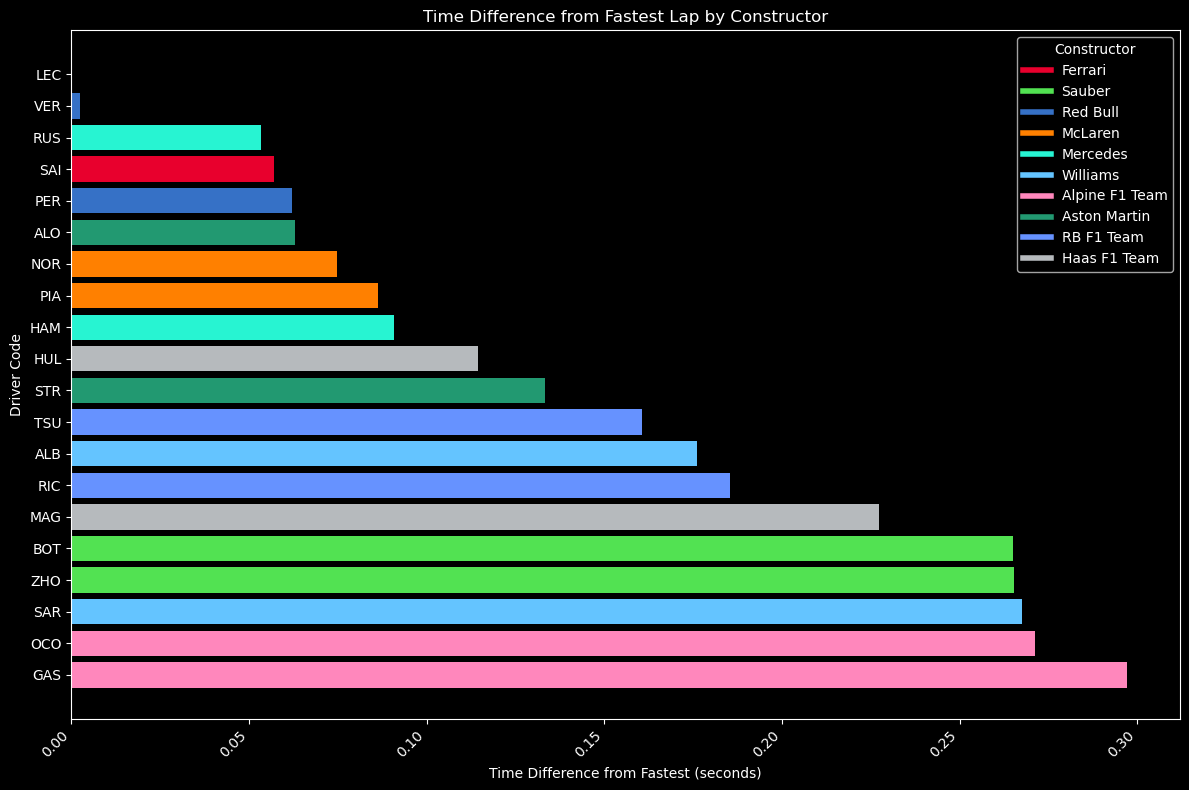

In [6]:
plot_qualifying_drivers(bahrain_qualifying)

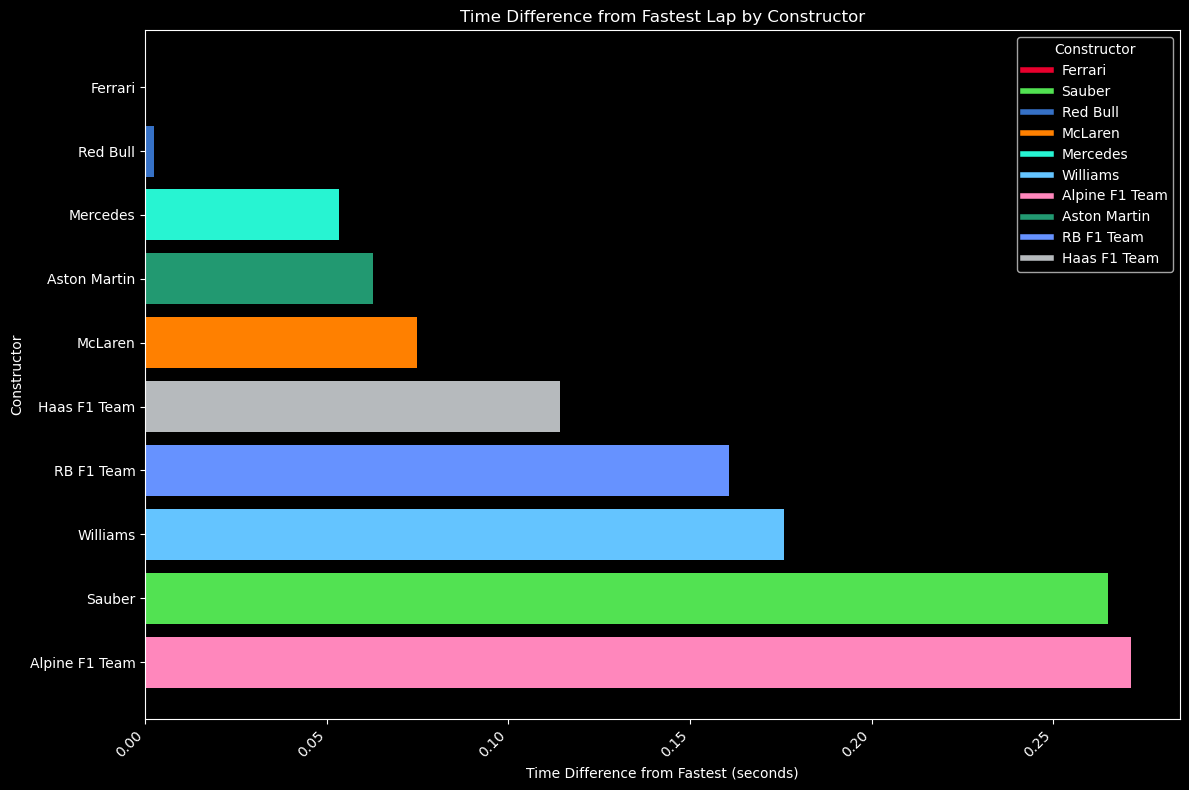

In [7]:
plot_time_diff_by_constructor(bahrain_qualifying)

# Race Analysis

In [8]:
races_subset = data['races'][['raceId', 'name', 'year']]
# Prepare lap times data for Bahrain Grand Prix
lap_times = pd.merge(data['lap_times'], races_subset[races_subset['year'] == 2024], on='raceId')
lap_times = pd.merge(lap_times, data['drivers'][['driverId', 'code', 'forename', 'surname']], on='driverId')
bahrain_gp = lap_times[lap_times['name'] == 'Bahrain Grand Prix'].copy()

results_subset = data['results'][['raceId', 'driverId', 'constructorId']]
bahrain_gp = pd.merge(bahrain_gp, results_subset, on=['raceId', 'driverId'])
bahrain_gp = pd.merge(bahrain_gp, data['constructors'][['constructorId', 'name']], on=['constructorId'])

In [9]:
# Convert lap times to minutes
bahrain_gp['lap_time_minutes'] = bahrain_gp['milliseconds'] / 60000

In [10]:
# Function to format y-axis ticks for minutes and seconds
def format_minutes(x, pos):
    minutes = int(x)
    seconds = (x - minutes) * 60
    return f'{minutes:02}:{seconds:05.3f}'

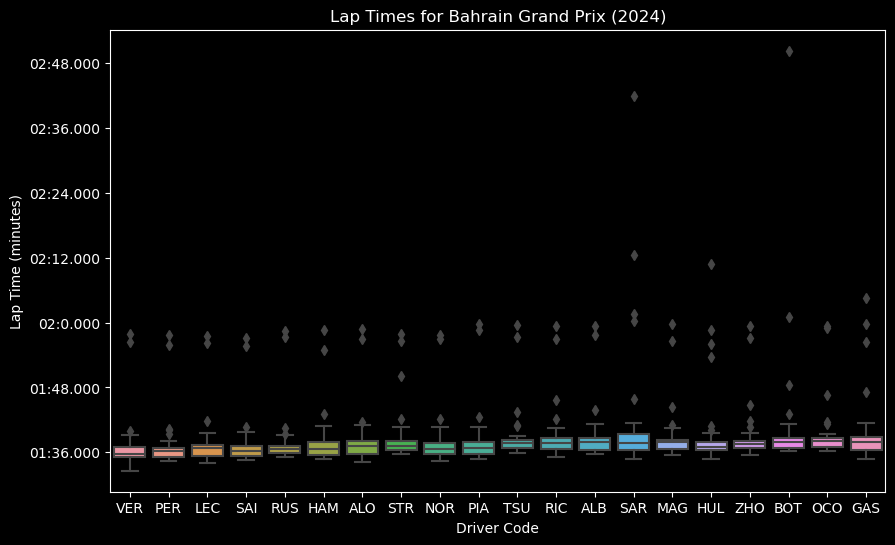

In [11]:
# Plot lap times boxplot for Bahrain Grand Prix
plt.style.use('dark_background')
plt.figure(figsize=(10, 6))
sns.boxplot(x='code', y='lap_time_minutes', data=bahrain_gp)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_minutes))
plt.xlabel('Driver Code')
plt.ylabel('Lap Time (minutes)')
plt.title('Lap Times for Bahrain Grand Prix (2024)')
plt.show()

In [12]:
# Remove outliers from lap times
Q1 = bahrain_gp['lap_time_minutes'].quantile(0.25)
Q3 = bahrain_gp['lap_time_minutes'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_bahrain_gp = bahrain_gp[(bahrain_gp['lap_time_minutes'] >= lower_bound) & (bahrain_gp['lap_time_minutes'] <= upper_bound)]

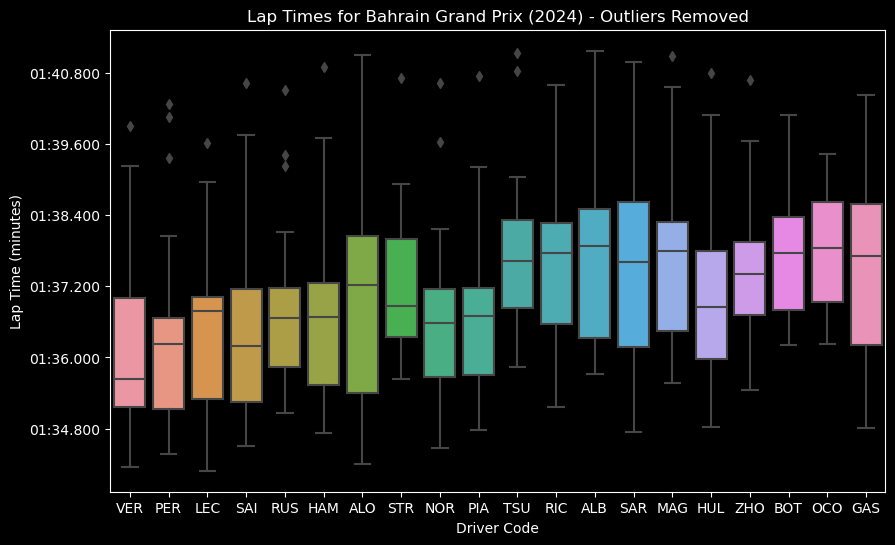

In [13]:
# Plot filtered lap times boxplot
plt.style.use('dark_background')
plt.figure(figsize=(10, 6))
sns.boxplot(x='code', y='lap_time_minutes', data=filtered_bahrain_gp)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_minutes))
plt.xlabel('Driver Code')
plt.ylabel('Lap Time (minutes)')
plt.title('Lap Times for Bahrain Grand Prix (2024) - Outliers Removed')
plt.show()

In [14]:
pit_stops = data['pit_stops']

In [15]:
# Merge lap times with pit stops to identify pitstop laps
merged_df = pd.merge(bahrain_gp, pit_stops[['raceId', 'driverId', 'lap']], 
                     on=['raceId', 'driverId', 'lap'], how='left', indicator=True)

In [16]:
# Identify pitstop laps
pitstop_laps = merged_df[merged_df['_merge'] == 'both']

In [17]:
# Find the laps immediately following the pitstops
next_lap_laps = pitstop_laps.copy()
next_lap_laps['lap'] += 1

# Combine pitstop laps and the next lap laps to create a DataFrame of laps to remove
laps_to_remove = pd.concat([pitstop_laps[['raceId', 'driverId', 'lap']], next_lap_laps[['raceId', 'driverId', 'lap']]])
laps_to_remove = laps_to_remove.drop_duplicates()

# Filter out laps with pitstops
bahrain_gp_no_pitstops = pd.merge(merged_df, laps_to_remove, 
                                  on=['raceId', 'driverId', 'lap'], how='left', indicator='remove_status')
bahrain_gp_no_pitstops = bahrain_gp_no_pitstops[bahrain_gp_no_pitstops['remove_status'] != 'both']

# Reset index for the cleaned DataFrame
bahrain_gp_no_pitstops.reset_index(drop=True, inplace=True)

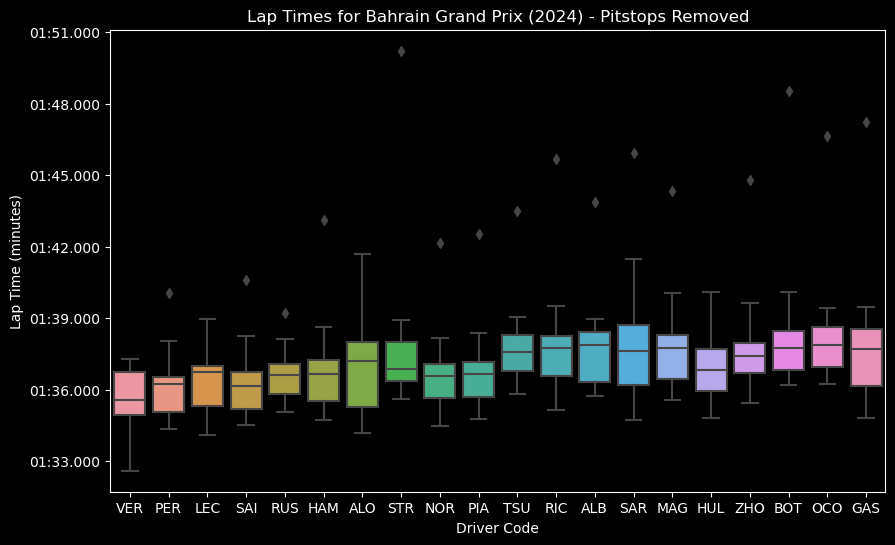

In [18]:
# Plot filtered lap times boxplot without pitstops
plt.style.use('dark_background')
plt.figure(figsize=(10, 6))
sns.boxplot(x='code', y='lap_time_minutes', data=bahrain_gp_no_pitstops)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_minutes))
plt.xlabel('Driver Code')
plt.ylabel('Lap Time (minutes)')
plt.title('Lap Times for Bahrain Grand Prix (2024) - Pitstops Removed')
plt.show()

In [19]:
# Merge driver names
driver_names = lap_times[['driverId', 'forename', 'surname']].drop_duplicates().set_index('driverId')

In [20]:
# Calculate and print mean and standard deviation of lap times
mean_lap_time_ms = bahrain_gp['milliseconds'].mean()
std_lap_time_ms = bahrain_gp['milliseconds'].std()
mean_lap_time = convert_to_time_format(mean_lap_time_ms)
std_lap_time = convert_to_time_format(std_lap_time_ms)

In [21]:
# Calculate statistics for each driver
stats = bahrain_gp.groupby('driverId')['milliseconds'].agg(['mean', 'std'])
stats = stats.join(driver_names, on='driverId')
stats['mean_time'] = stats['mean'].apply(convert_to_time_format)
stats['std_time'] = stats['std'].apply(convert_to_time_format)

In [22]:
# Display sorted statistics
stats_subset = stats[['forename', 'surname', 'mean_time', 'std_time']]
stats_subset.sort_values("std_time")

,forename,surname,mean_time,std_time
driverId,,,,
832,Carlos,Sainz,1:37.014,0:03.966
844,Charles,Leclerc,1:37.270,0:04.004
815,Sergio,Pérez,1:36.968,0:04.026
1,Lewis,Hamilton,1:37.457,0:04.049
846,Lando,Norris,1:37.424,0:04.076
847,George,Russell,1:37.395,0:04.096
855,Guanyu,Zhou,1:38.419,0:04.119
852,Yuki,Tsunoda,1:38.468,0:04.121
825,Kevin,Magnussen,1:38.447,0:04.122


In [23]:
# Calculate and print mean and standard deviation of lap times after removing outliers
mean_lap_time_ms_filtered = filtered_bahrain_gp['milliseconds'].mean()
std_lap_time_ms_filtered = filtered_bahrain_gp['milliseconds'].std()
mean_lap_time_filtered = convert_to_time_format(mean_lap_time_ms_filtered)
std_lap_time_filtered = convert_to_time_format(std_lap_time_ms_filtered)

In [24]:
# Calculate statistics for each driver after removing outliers
stats = filtered_bahrain_gp.groupby('driverId')['milliseconds'].agg(['mean', 'std'])
stats = stats.join(driver_names, on='driverId')
stats['mean_time'] = stats['mean'].apply(convert_to_time_format)
stats['std_time'] = stats['std'].apply(convert_to_time_format)

In [25]:
# Display sorted statistics
stats_subset = stats[['forename', 'surname', 'mean_time', 'std_time']]
stats_subset.sort_values("std_time")

,forename,surname,mean_time,std_time
driverId,,,,
839,Esteban,Ocon,1:37.810,0:00.934
822,Valtteri,Bottas,1:37.719,0:00.973
855,Guanyu,Zhou,1:37.470,0:00.978
840,Lance,Stroll,1:37.192,0:01.040
852,Yuki,Tsunoda,1:37.617,0:01.122
847,George,Russell,1:36.650,0:01.145
844,Charles,Leclerc,1:36.463,0:01.212
846,Lando,Norris,1:36.599,0:01.213
857,Oscar,Piastri,1:36.664,0:01.221


In [26]:
# Calculate and print mean and standard deviation of lap times without pitstops
mean_lap_time_ms_no_pitstops = bahrain_gp_no_pitstops['milliseconds'].mean()
std_lap_time_ms_no_pitstops = bahrain_gp_no_pitstops['milliseconds'].std()
mean_lap_time_no_pitstops = convert_to_time_format(mean_lap_time_ms_no_pitstops)
std_lap_time_no_pitstops = convert_to_time_format(std_lap_time_ms_no_pitstops)

In [27]:
# Calculate statistics for each driver after removing pitstops
stats = bahrain_gp_no_pitstops.groupby('driverId')['milliseconds'].agg(['mean', 'std'])
stats = stats.join(driver_names, on='driverId')
stats['mean_time'] = stats['mean'].apply(convert_to_time_format)
stats['std_time'] = stats['std'].apply(convert_to_time_format)

In [28]:
# Display sorted statistics
stats_subset = stats[['forename', 'surname', 'mean_time', 'std_time']]
stats_subset.sort_values("std_time")

,forename,surname,mean_time,std_time
driverId,,,,
847,George,Russell,1:36.526,0:00.955
807,Nico,Hülkenberg,1:36.854,0:01.067
830,Max,Verstappen,1:35.685,0:01.079
844,Charles,Leclerc,1:36.404,0:01.142
815,Sergio,Pérez,1:36.115,0:01.168
832,Carlos,Sainz,1:36.188,0:01.222
852,Yuki,Tsunoda,1:37.600,0:01.230
846,Lando,Norris,1:36.571,0:01.267
857,Oscar,Piastri,1:36.650,0:01.317


In [29]:
# Comparison Summary
print("\nComparison of Mean Lap Times and Standard Deviations:")
print(f"1. Unfiltered Data      - Mean Lap Time: {mean_lap_time}, Standard Deviation: {std_lap_time}")
print(f"2. Outliers Removed     - Mean Lap Time: {mean_lap_time_filtered}, Standard Deviation: {std_lap_time_filtered}")
print(f"3. Pitstops Removed     - Mean Lap Time: {mean_lap_time_no_pitstops}, Standard Deviation: {std_lap_time_no_pitstops}")


Comparison of Mean Lap Times and Standard Deviations:
1. Unfiltered Data      - Mean Lap Time: 1:38.124, Standard Deviation: 0:05.333
2. Outliers Removed     - Mean Lap Time: 1:37.036, Standard Deviation: 0:01.356
3. Pitstops Removed     - Mean Lap Time: 1:37.050, Standard Deviation: 0:01.591


In [30]:
def calculate_driver_stats(df, label):
    # Group by both driverId and constructor_name
    stats = df.groupby(['driverId', 'name_y'])['milliseconds'].agg(['mean', 'std']).reset_index()
    
    # Rename the columns to include the label
    stats.columns = ['driverId', 'name_y', f'{label}_mean', f'{label}_std']
    
    return stats

In [31]:
# Calculate statistics for each driver (Unfiltered, Filtered, No Pitstops)
unfiltered_stats = calculate_driver_stats(bahrain_gp, 'unfiltered')
filtered_stats = calculate_driver_stats(filtered_bahrain_gp, 'filtered')
no_pitstops_stats = calculate_driver_stats(bahrain_gp_no_pitstops, 'no_pitstops')

# Combine the statistics for comparison
combined_stats = pd.merge(unfiltered_stats, filtered_stats, on=['driverId', 'name_y'])
combined_stats = pd.merge(combined_stats, no_pitstops_stats, on=['driverId', 'name_y'])
combined_stats = combined_stats.join(driver_names, on='driverId')
combined_stats = combined_stats[['forename', 'surname', 'name_y', 'unfiltered_mean', 'unfiltered_std', 'filtered_mean', 'filtered_std', 'no_pitstops_mean', 'no_pitstops_std']]

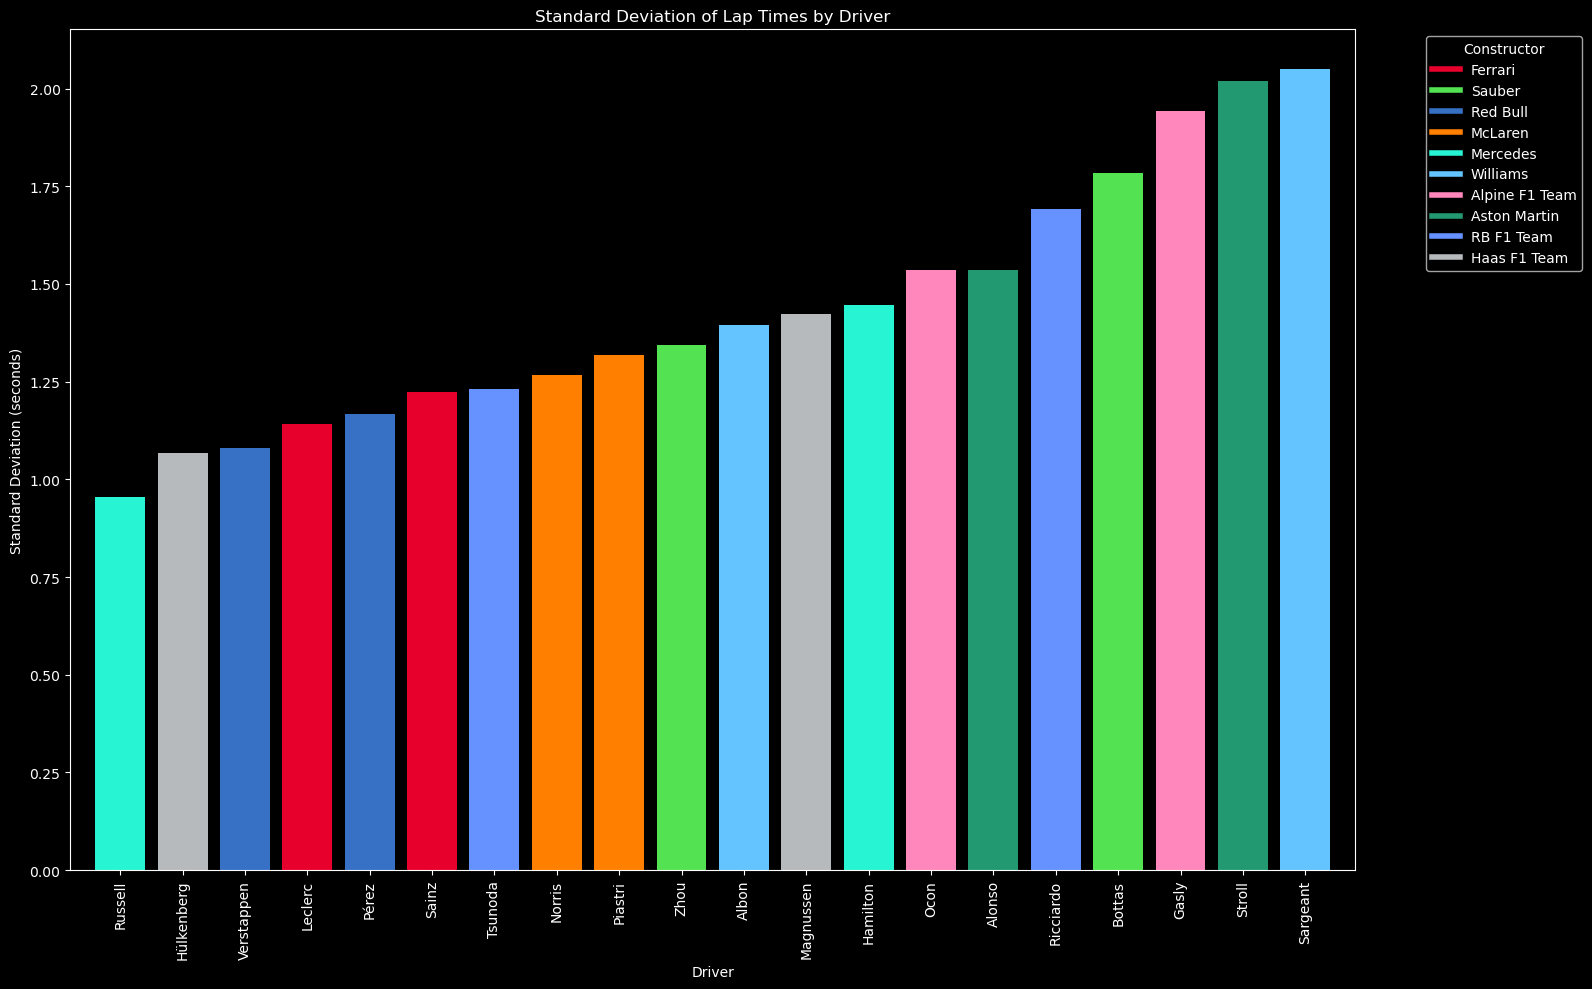

In [32]:
# Create a new DataFrame for plotting
plot_data = combined_stats.reset_index()
plot_data = plot_data.melt(id_vars=['forename', 'surname', 'name_y'], 
                           #value_vars=['unfiltered_std', 'no_pitstops_std', 'filtered_std'], 
                           value_vars=['no_pitstops_std'],
                           var_name='Scenario', 
                           value_name='Standard Deviation')

# Convert standard deviation values to seconds
plot_data['Standard Deviation (s)'] = pd.to_numeric(plot_data['Standard Deviation'], errors='coerce') / 1000

# Sort the DataFrame by Standard Deviation (seconds) from lowest to highest
plot_data_sorted = plot_data.sort_values(by='Standard Deviation (s)')

# Prepare data for plotting
drivers = plot_data_sorted['surname'].unique()
x = np.arange(len(drivers))  # the label locations
bar_width = 0.8  # Width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(16, 10))  # Increase figure size

# Create bars with constructor colors
bars = ax.bar(x, plot_data_sorted['Standard Deviation (s)'], 
              color=plot_data_sorted['name_y'].map(constructor_colors),
              width=bar_width, align='center')

# Add labels, title, and customize tick labels
ax.set_xlabel('Driver')
ax.set_ylabel('Standard Deviation (seconds)')
ax.set_title('Standard Deviation of Lap Times by Driver')

# Add x-ticks with labels
ax.set_xticks(x)
ax.set_xticklabels(drivers, rotation=90)  # Rotate x labels for better readability

# Adjust x-axis limits to remove gaps
ax.set_xlim(-bar_width, len(drivers) - 1 + bar_width)

# Add a legend with constructors
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in constructor_colors.values()]
labels = list(constructor_colors.keys())
ax.legend(handles, labels, title='Constructor', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

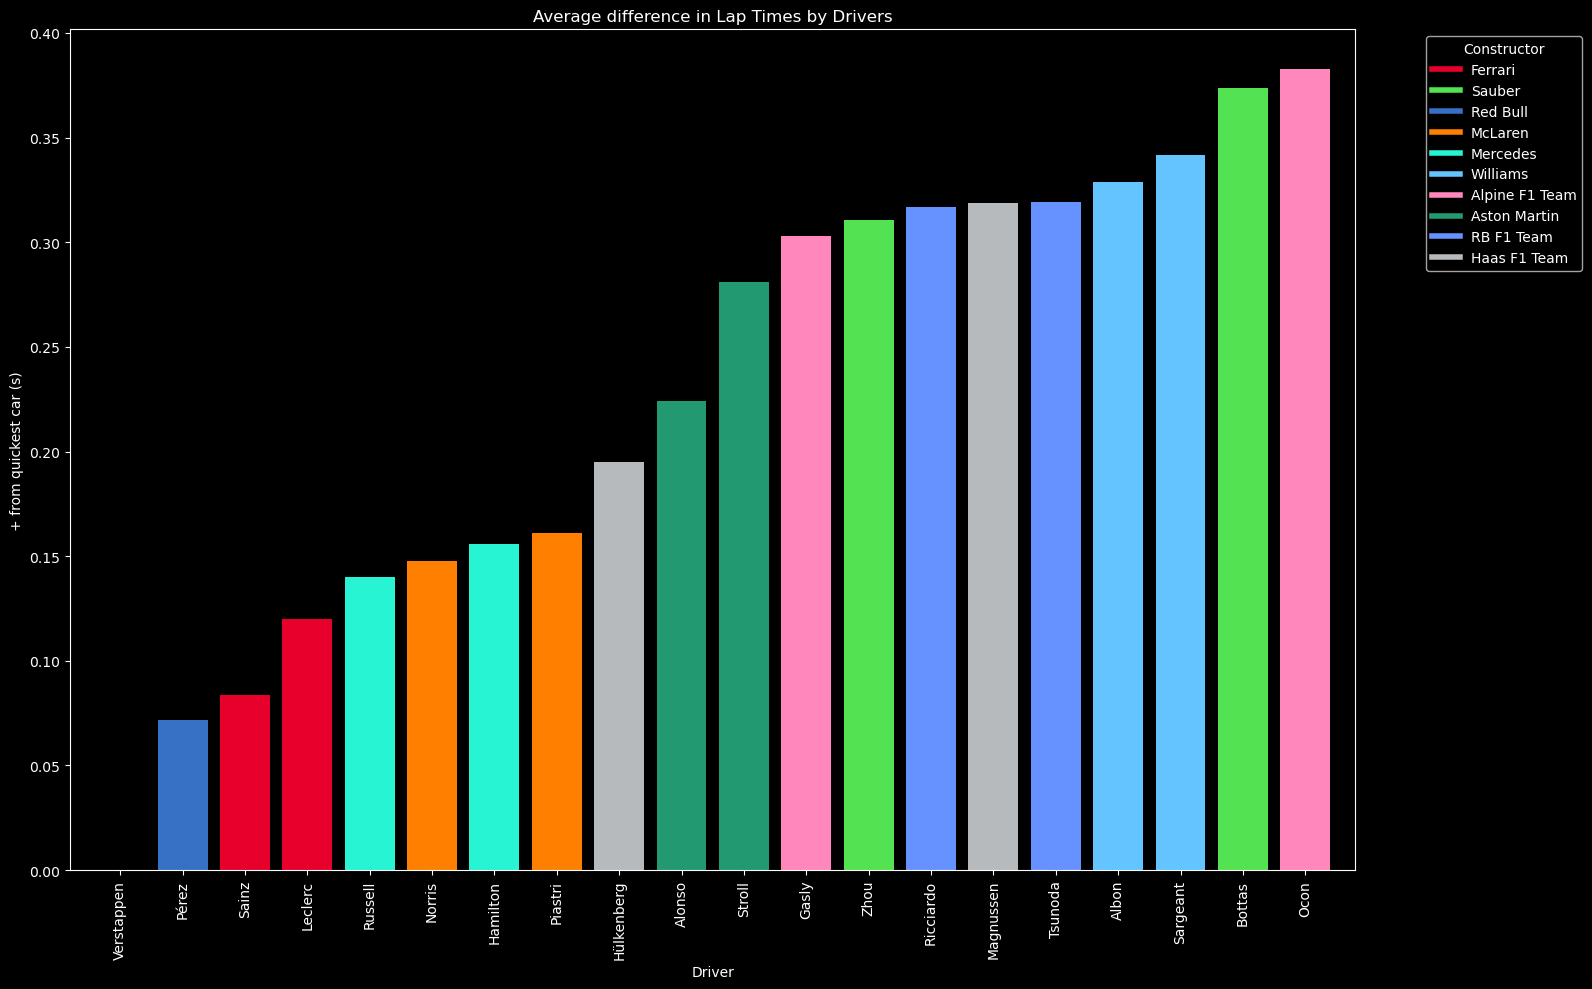

In [33]:
plot_data = combined_stats.reset_index()
plot_data = plot_data.melt(id_vars=['forename', 'surname', 'name_y'], 
                           #value_vars=['unfiltered_std', 'no_pitstops_std', 'filtered_std'], 
                           value_vars=['no_pitstops_mean'],
                           var_name='Scenario', 
                           value_name='Mean')

# Sort the DataFrame by Standard Deviation (seconds) from lowest to highest
plot_data_sorted = plot_data.sort_values(by='Mean')

plot_data_sorted['Dif_from_fastest'] =  (plot_data_sorted['Mean'] - plot_data_sorted['Mean'].min()) / 6000

# Prepare data for plotting
drivers = plot_data_sorted['surname'].unique()
x = np.arange(len(drivers))  # the label locations
bar_width = 0.8  # Width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(16, 10))  # Increase figure size

# Create bars with constructor colors
bars = ax.bar(x, plot_data_sorted['Dif_from_fastest'], 
              color=plot_data_sorted['name_y'].map(constructor_colors),
              width=bar_width, align='center')

# Add labels, title, and customize tick labels
ax.set_xlabel('Driver')
ax.set_ylabel('+ from quickest car (s)')
ax.set_title('Average difference in Lap Times by Drivers')

# Add x-ticks with labels
ax.set_xticks(x)
ax.set_xticklabels(drivers, rotation=90)  # Rotate x labels for better readability

# Adjust x-axis limits to remove gaps
ax.set_xlim(-bar_width, len(drivers) - 1 + bar_width)

# Add a legend with constructors
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in constructor_colors.values()]
labels = list(constructor_colors.keys())
ax.legend(handles, labels, title='Constructor', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

## Predictor from https://www.kaggle.com/code/sevrussnape/data-analytics-project/notebook#3.-Race-Strategy-Optimization-via-Simulation

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Filter races for the Italian Grand Prix from the past 10 years
recent_years = [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
races = data['races']
italian_gp_recent = races[(races['name'].str.contains("British Grand Prix")) & (races['year'].isin(recent_years))]

# Merge qualifying data with Italian GP data
qualifying = data['qualifying']
qualifying_italian_gp_recent = qualifying[qualifying['raceId'].isin(italian_gp_recent['raceId'])]

# Merge results data with Italian GP data
results = data['results']
results_italian_gp_recent = results[results['raceId'].isin(italian_gp_recent['raceId'])]

# Calculate average qualifying position and race position
avg_qualifying_position = qualifying_italian_gp_recent.groupby('driverId')['position'].mean().reset_index().rename(columns={'position': 'avg_qualifying_position'})
avg_race_position = results_italian_gp_recent.groupby('driverId')['positionOrder'].mean().reset_index().rename(columns={'positionOrder': 'avg_race_position'})

# Merge features
features = avg_qualifying_position.merge(avg_race_position, on='driverId')

# Create a binary target variable for race winners
results_italian_gp_recent = results_italian_gp_recent.copy()  # Create a copy to avoid SettingWithCopyWarning
results_italian_gp_recent.loc[:, 'winner'] = results_italian_gp_recent['positionOrder'] == 1
race_winners_recent = results_italian_gp_recent[['raceId', 'driverId', 'winner']]
race_winners_recent = race_winners_recent[race_winners_recent['winner']].drop(columns=['winner'])

# Merge target with features
data_recent = features.merge(race_winners_recent, on='driverId', how='left').fillna(0)

# Prepare data for model
X = data_recent[['avg_qualifying_position', 'avg_race_position']]
y = data_recent['driverId'].apply(lambda x: 1 if x in race_winners_recent['driverId'].values else 0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Filter drivers participating in the 2024 championship
races_2024 = races[races['year'] == 2024]
results_2024 = results[results['raceId'].isin(races_2024['raceId'])]

# Get unique driver IDs for the 2024 season
drivers_2024_ids = results_2024['driverId'].unique()

# Sample average qualifying and race positions for drivers competing in 2024
latest_qualifying_position = qualifying[qualifying['driverId'].isin(drivers_2024_ids) & qualifying['raceId'].isin(races_2024['raceId'])].groupby('driverId')['position'].mean().reset_index().rename(columns={'position': 'avg_qualifying_position'})
latest_race_position = results[results['driverId'].isin(drivers_2024_ids) & results['raceId'].isin(races_2024['raceId'])].groupby('driverId')['positionOrder'].mean().reset_index().rename(columns={'positionOrder': 'avg_race_position'})

# Merge features for prediction
latest_features = latest_qualifying_position.merge(latest_race_position, on='driverId')

# Predict
latest_features['predicted_winner'] = model.predict(latest_features[['avg_qualifying_position', 'avg_race_position']])

# Map driver IDs to names
drivers = data['drivers']
driver_id_to_name = dict(zip(drivers['driverId'], drivers['surname']))
latest_features['driver'] = latest_features['driverId'].map(driver_id_to_name)

# Show predictions
print(latest_features[['driver', 'avg_qualifying_position', 'avg_race_position', 'predicted_winner']])

Accuracy: 0.9285714285714286
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.67      1.00      0.80         2

    accuracy                           0.93        14
   macro avg       0.83      0.96      0.88        14
weighted avg       0.95      0.93      0.93        14

        driver  avg_qualifying_position  avg_race_position  predicted_winner
0     Hamilton                 7.750000           6.916667                 1
1       Alonso                10.000000           9.833333                 0
2   Hülkenberg                11.666667          10.916667                 0
3        Pérez                 8.250000           7.833333                 0
4    Ricciardo                13.166667          13.583333                 0
5       Bottas                15.166667          15.916667                 0
6    Magnussen                15.666667          13.583333                 0
7   